In [2]:
'''
LeNet-5 architecture
+---------+-----------------+-------------------------------+------------------+
| Layer   | Type            | Configuration                 | Output Size      |
+---------+-----------------+-------------------------------+------------------+
| Input   | Image           | 32 x 32 x 1 (Grayscale)       | 32 x 32 x 1      |
| C1      | Convolution     | 6 filters (5x5), Stride 1     | 28 x 28 x 6      |
| S2      | Avg Pooling     | 2x2 window, Stride 2          | 14 x 14 x 6      |
| C3      | Convolution     | 16 filters (5x5), Stride 1    | 10 x 10 x 16     |
| S4      | Avg Pooling     | 2x2 window, Stride 2          | 5 x 5 x 16       |
| C5      | Convolution     | 120 filters (5x5), Stride 1   | 1 x 1 x 120      |
| F6      | Fully Connected | 84 Neurons                    | 84               |
| Output  | Fully Connected | 10 Neurons (Softmax)          | 10               |
+---------+-----------------+-------------------------------+------------------+

LeNet-5 was designed for handwritten digit recognition (MNIST) and pioneered the use of convolutional layers. 

It originally used tanh activation functions and average pooling instead of ReLU and max pooling found in modern architectures. 

The C5 layer effectively flattens the feature maps to 120 values, 
transitioning from convolutional to fully connected layers.
'''

'\nLeNet-5 architecture\n+---------+-----------------+-------------------------------+------------------+\n| Layer   | Type            | Configuration                 | Output Size      |\n+---------+-----------------+-------------------------------+------------------+\n| Input   | Image           | 32 x 32 x 1 (Grayscale)       | 32 x 32 x 1      |\n| C1      | Convolution     | 6 filters (5x5), Stride 1     | 28 x 28 x 6      |\n| S2      | Avg Pooling     | 2x2 window, Stride 2          | 14 x 14 x 6      |\n| C3      | Convolution     | 16 filters (5x5), Stride 1    | 10 x 10 x 16     |\n| S4      | Avg Pooling     | 2x2 window, Stride 2          | 5 x 5 x 16       |\n| C5      | Convolution     | 120 filters (5x5), Stride 1   | 1 x 1 x 120      |\n| F6      | Fully Connected | 84 Neurons                    | 84               |\n| Output  | Fully Connected | 10 Neurons (Softmax)          | 10               |\n+---------+-----------------+-------------------------------+------------

In [3]:
#########################
## Importing libraries ##
#########################

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# cuda

cuda


In [ ]:
#########################
## Dataset downloading ##
#########################
'''
Import MNIST dataset from HuggingFace
Run this first in terminal: pip install datasets
'''

from datasets import load_dataset

train_set = load_dataset(
    'mnist',
    split='train',
    verification_mode='basic_checks'
)
print(train_set)
# Dataset({
#     features: ['image', 'label'],
#     num_rows: 60000
# })

val_set = load_dataset(
    'mnist',
    split='test',
    verification_mode='basic_checks'
)
print(val_set)
# Dataset({
#     features: ['image', 'label'],
#     num_rows: 10000
# })

# View an image
train_set[0]['image']

print(train_set[0]['image'])
# <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x6FFF3C175B80>

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x6FFF3C175B80>


In [5]:
#########################
## Image preprocessing ##
#########################

IMG_SIZE = 32
'''
LeNet-5 is designed to accept 32x32 grayscale images
=> Must resize MNIST images from 28x28 to 32x32
'''

#----
## Build preprocess transforms
#----

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize from 28x28 to 32x32
        transforms.ToTensor()                      # Convert to tensor (and also convert to [0, 1] tensors)
    ]
)

#----
## Apply preprocess to training set
#----

inputs_train = []

for record in tqdm(iterable=train_set, desc="Preprocessing Images"):
    image = record['image']
    label = record['label']
    
    # preprocessing
    input_tensor = preprocess(image)
    label_tensor = torch.tensor(label)
    
    # append to inputs_train
    inputs_train.append([input_tensor, label_tensor])


Preprocessing Images:   0%|          | 0/60000 [00:00<?, ?it/s]

In [11]:
#----
## Re-normalize the pixel values for train set
#----
'''
Since transforms.ToTensor() normalizes all into [0, 1],
we need to modify this normalization to fit MNIST dataset.

Calculate the mean and std for grayscale images (single channel)
then use transforms.Normalize(mean=, std=) with this calculated mean and std.
'''

import numpy as np

# Choosing a random sample to calculate mean and std (512 images)
np.random.seed(0)
idx = np.random.randint(0, len(inputs_train), 512)

# Concatenate this subset of images into a new tensor
tensor_placeholder = torch.concat([inputs_train[i][0] for i in idx], axis=1)
print(tensor_placeholder.shape)
# torch.Size([1, 16384, 32])
'''
we concatenate 512 images of size (1x32x32) (Channel*Height*Width) along the Height channel
=> (1x16384x32), 16384=32*512
'''

# Calculate the mean and std across all images
mean_all = torch.mean(tensor_placeholder, dim=(1, 2))
std_all = torch.std(tensor_placeholder, dim=(1, 2))

print(mean_all)  # tensor([0.1317])
print(std_all)   # tensor([0.2902])

#### RE-NORMALIZE ###

preprocess = transforms.Compose([transforms.Normalize(mean=mean_all, std=std_all)])

for idx in tqdm(range(len(inputs_train))):
    input_tensor = preprocess(inputs_train[idx][0])
    inputs_train[idx][0] = input_tensor  # replace with re-normalized tensor


torch.Size([1, 16384, 32])
tensor([1.0850e-07])
tensor([1.0000])


  0%|          | 0/60000 [00:00<?, ?it/s]

In [7]:
#----
## Re-normalize the pixel values for val set
#----

preprocess_full = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_all, std=std_all)
    ]
)

inputs_val = []

for record in tqdm(iterable=val_set, desc="Preprocessing Images"):
    image = record['image']
    label = record['label']
    
    # preprocessing
    input_tensor = preprocess_full(image)
    label_tensor = torch.tensor(label)
    
    # append to inputs_val
    inputs_val.append([input_tensor, label_tensor])

Preprocessing Images:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
################
## Dataloader ##
################

BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(inputs_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(inputs_val, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
############################
## Building LeNet-5 Model ##
############################
'''
LeNet-5 architecture follows a simple pattern:
Conv → AvgPool → Conv → AvgPool → Conv → FC → FC → Output

The architecture uses:
- 5x5 convolutional kernels
- Average pooling (2x2 with stride 2)
- Tanh activation (we use ReLU for modern implementation)
- Gradual increase in channels: 1 → 6 → 16 → 120

How spatial dimensions change:
Input 32x32x1 
→ C1: Conv(6, 5x5) → 28x28x6
→ S2: AvgPool(2x2) → 14x14x6
→ C3: Conv(16, 5x5) → 10x10x16
→ S4: AvgPool(2x2) → 5x5x16
→ C5: Conv(120, 5x5) → 1x1x120 (this effectively flattens to 120)
→ F6: Linear(120, 84)
→ Output: Linear(84, 10)
'''

class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            # C1: Convolutional Layer
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),  # Modern implementation uses ReLU instead of tanh
            
            # S2: Average Pooling Layer
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            # C3: Convolutional Layer
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            
            # S4: Average Pooling Layer
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            # C5: Convolutional Layer (acts as fully connected)
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU(),
            
            # Flatten the output for fully connected layers
            nn.Flatten(),
            
            # F6: Fully Connected Layer
            nn.LazyLinear(84), # LazyLinear() will automatically infer the input_size for us (120 -> 84) 
            nn.ReLU(),
            
            # Output Layer
            nn.Linear(84, num_classes)
        )
        
    def forward(self, X):
        out = self.cnn(X)
        return out

'''
Spatial dimension calculations:

C1: Conv2d (kernel=5, stride=1, padding=0):
    output = (32 - 5)/1 + 1 = 28 → (batch, 6, 28, 28)

S2: AvgPool (kernel=2, stride=2):
    output = (28 - 2)/2 + 1 = 14 → (batch, 6, 14, 14)

C3: Conv2d (kernel=5, stride=1, padding=0):
    output = (14 - 5)/1 + 1 = 10 → (batch, 16, 10, 10)

S4: AvgPool (kernel=2, stride=2):
    output = (10 - 2)/2 + 1 = 5 → (batch, 16, 5, 5)

C5: Conv2d (kernel=5, stride=1, padding=0):
    output = (5 - 5)/1 + 1 = 1 → (batch, 120, 1, 1)

After Flatten:
    120 channels × 1 height × 1 width = 120 features
    Final shape: (batch, 120) → ready for nn.Linear(120, 84)

#################

Formula for Conv2d output size:
    output_size = (input_size - kernel_size + 2*padding) / stride + 1
'''

'\nSpatial dimension calculations:\n\nC1: Conv2d (kernel=5, stride=1, padding=0):\n    output = (32 - 5)/1 + 1 = 28 → (batch, 6, 28, 28)\n\nS2: AvgPool (kernel=2, stride=2):\n    output = (28 - 2)/2 + 1 = 14 → (batch, 6, 14, 14)\n\nC3: Conv2d (kernel=5, stride=1, padding=0):\n    output = (14 - 5)/1 + 1 = 10 → (batch, 16, 10, 10)\n\nS4: AvgPool (kernel=2, stride=2):\n    output = (10 - 2)/2 + 1 = 5 → (batch, 16, 5, 5)\n\nC5: Conv2d (kernel=5, stride=1, padding=0):\n    output = (5 - 5)/1 + 1 = 1 → (batch, 120, 1, 1)\n\nAfter Flatten:\n    120 channels × 1 height × 1 width = 120 features\n    Final shape: (batch, 120) → ready for nn.Linear(120, 84)\n\n#################\n\nFormula for Conv2d output size:\n    output_size = (input_size - kernel_size + 2*padding) / stride + 1\n'

In [22]:
##########################
## Model initialization ##
##########################

num_classes = 10  # MNIST has 10 digit classes (0-9)
print(num_classes)

torch.manual_seed(42)
model = LeNet5(num_classes=num_classes).to(device)

# Initialize lazy layers
with torch.no_grad():
    dummy = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(device)  # Match your input size
    _ = model(dummy)

##################################
## Loss - Optimizer - Scheduler ##
##################################

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)

10


In [23]:
################################
## Training - Validating loop ##
################################

epochs = 20  # LeNet-5 on MNIST converges faster than AlexNet on CIFAR-10

train_loss_list, val_loss_list = [], []

for epoch in tqdm(iterable=range(1, epochs+1), desc="Training"):
    # --- TRAINING ---
    _ = model.train()
    for _, (images, labels) in enumerate(train_loader):
        # moves values to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Standard training steps
        preds = model(images).squeeze()
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for _, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            val_preds = model(images).squeeze()
            
            # Accumulate loss
            val_loss += loss_fn(val_preds, labels).item()
            
            # Calculate accuracy
            total += labels.size(0)
            predicted = torch.argmax(val_preds, dim=1)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = 100 * (correct / total)
    
    train_loss_list.append(loss.item())
    val_loss_list.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step(avg_val_loss)
    
    if (epoch % 5 == 0) or (epoch == 1):
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {avg_val_acc:.2f}%")
        print(f"Current LR: {current_lr}")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1
Train loss: 0.0535
Validation loss: 0.0731
Validation accuracy: 97.79%
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 5
Train loss: 0.1509
Validation loss: 0.0328
Validation accuracy: 98.89%
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10
Train loss: 0.0018
Validation loss: 0.0296
Validation accuracy: 99.13%
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 15
Train loss: 0.0043
Validation loss: 0.0446
Validation accuracy: 98.86%
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20
Train loss: 0.0001
Validation loss: 0.0386
Validation accuracy: 99.25%
Current LR: 0.0005


In [24]:
#######################################
## Drawing Train and Val loss curves ##
#######################################

def plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list):
    import plotly.graph_objects as pgo
    import numpy as np
    
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    fig.update_layout(
        title='<b>LeNet-5 Training Progress on MNIST</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark',
        hovermode='x unified',
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()

plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list)

In [25]:
################################################
## Confusion matrix and Classification report ##
################################################

from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for images, labels in val_loader:
        images = images.to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print classification report
print('Classification report\n', classification_report(all_labels, all_preds))
# Classification report
#                precision    recall  f1-score   support

#            0       1.00      1.00      1.00       980
#            1       1.00      1.00      1.00      1135
#            2       0.99      1.00      0.99      1032
#            3       0.99      1.00      0.99      1010
#            4       0.99      1.00      0.99       982
#            5       0.99      0.99      0.99       892
#            6       1.00      0.99      1.00       958
#            7       0.99      0.99      0.99      1028
#            8       1.00      0.99      0.99       974
#            9       0.99      0.99      0.99      1009

#     accuracy                           0.99     10000
#    macro avg       0.99      0.99      0.99     10000
# weighted avg       0.99      0.99      0.99     10000

import plotly.express as px

# MNIST digit classes
class_names = [str(i) for i in range(10)]

fig = px.imshow(
    cm,
    text_auto=True,
    labels=dict(x="Predicted", y="Actual", color="Count"),
    x=class_names,
    y=class_names,
    color_continuous_scale='Blues',
    title='LeNet-5 Confusion Matrix on MNIST (Interactive)'
)

fig.update_layout(
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=700,
    height=700
)

fig.show()

Classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.98      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [26]:
########################
## Saving whole model ##
########################

from pathlib import Path

MODEL_PATH = Path("04_CNN").joinpath("save")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

PARAMS_NAME = "LeNet5_model.pth"

# Save the model
torch.save(obj=model, f=MODEL_PATH.joinpath(PARAMS_NAME))

In [ ]:
###############
## Inference ##
###############

model_loaded = torch.load(MODEL_PATH.joinpath(PARAMS_NAME), weights_only=False)

_ = model_loaded.eval().to(device)

inference_inputs = []
for image in val_set['image'][:10]:  # Use 10 images for inference demonstration
    tensor = preprocess_full(image)
    inference_inputs.append(tensor.to(device))

print(inference_inputs[0].shape)
# torch.Size([1, 32, 32])

print(len(inference_inputs))
# 10

inference_inputs = torch.stack(inference_inputs)
print(inference_inputs.shape)
# torch.Size([10, 1, 32, 32])

inference_outputs = model_loaded(inference_inputs)
print(inference_outputs)
# tensor([[-2.3858e+01, -5.1395e+00, -1.0026e+01, -7.1979e+00, -3.9770e+00,
#          -1.9150e+01, -3.8184e+01,  2.4786e+01, -8.6416e+00, -3.5825e+00],
#         [-6.5254e+00, -2.8773e+00,  2.9795e+01, -1.2022e+01, -8.6533e+00,
#          -2.3611e+01, -4.6467e+00, -1.3890e+01, -1.1569e+01, -2.8425e+01],
#         [-1.3018e+01,  1.4856e+01, -1.1752e+01, -2.0149e+01, -1.6110e+00,
#          -7.2483e+00, -7.7743e+00, -6.0461e-01, -2.9084e+00, -1.3665e+01],
#         [ 1.9816e+01, -2.0723e+01, -9.6254e+00, -1.5709e+01, -1.0649e+01,
#          -1.0625e+01, -1.1768e+00, -1.8065e+01, -1.2069e+01, -2.9945e+00],
#         [-1.6542e+01, -8.6741e+00, -1.1720e+01, -2.4561e+01,  2.3231e+01,
#          -1.5178e+01, -1.1694e+01, -8.4690e+00, -1.3377e+01,  4.5189e+00],
#         [-1.4530e+01,  1.7627e+01, -1.3264e+01, -2.2885e+01, -3.5202e+00,
#          -9.4974e+00, -1.1358e+01,  3.2740e-01, -2.0507e+00, -1.6039e+01],
#         [-2.6542e+01, -5.7028e+00, -8.5020e+00, -2.1896e+01,  1.5752e+01,
#          -1.3248e+01, -1.4856e+01, -7.7289e+00, -2.2026e+00,  1.7383e-01],
#         [-1.7427e+01, -1.6647e+01, -3.4704e+00, -2.7922e+00, -2.7330e+00,
#          -1.8873e+01, -3.6574e+01, -1.7888e+01, -4.1861e+00,  2.0485e+01],
#         [-1.3796e+01, -9.3176e+00, -2.2982e+01, -1.4894e+01, -9.3404e+00,
#           1.6623e+01,  3.1275e+00, -1.7701e+01, -3.7895e+00,  3.4103e-02],
#         [-2.5642e+01, -1.2811e+01, -2.0516e+01, -9.4124e+00,  3.1344e+00,
#          -1.8876e+01, -4.3080e+01, -1.1528e+00, -5.4452e+00,  2.3623e+01]],
#        device='cuda:0', grad_fn=<AddmmBackward0>)

predicted = torch.argmax(inference_outputs, dim=1)
print(predicted)
# tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')

torch.Size([1, 32, 32])
10
torch.Size([10, 1, 32, 32])
tensor([[-2.3858e+01, -5.1395e+00, -1.0026e+01, -7.1979e+00, -3.9770e+00,
         -1.9150e+01, -3.8184e+01,  2.4786e+01, -8.6416e+00, -3.5825e+00],
        [-6.5254e+00, -2.8773e+00,  2.9795e+01, -1.2022e+01, -8.6533e+00,
         -2.3611e+01, -4.6467e+00, -1.3890e+01, -1.1569e+01, -2.8425e+01],
        [-1.3018e+01,  1.4856e+01, -1.1752e+01, -2.0149e+01, -1.6110e+00,
         -7.2483e+00, -7.7743e+00, -6.0461e-01, -2.9084e+00, -1.3665e+01],
        [ 1.9816e+01, -2.0723e+01, -9.6254e+00, -1.5709e+01, -1.0649e+01,
         -1.0625e+01, -1.1768e+00, -1.8065e+01, -1.2069e+01, -2.9945e+00],
        [-1.6542e+01, -8.6741e+00, -1.1720e+01, -2.4561e+01,  2.3231e+01,
         -1.5178e+01, -1.1694e+01, -8.4690e+00, -1.3377e+01,  4.5189e+00],
        [-1.4530e+01,  1.7627e+01, -1.3264e+01, -2.2885e+01, -3.5202e+00,
         -9.4974e+00, -1.1358e+01,  3.2740e-01, -2.0507e+00, -1.6039e+01],
        [-2.6542e+01, -5.7028e+00, -8.5020e+00, -2.

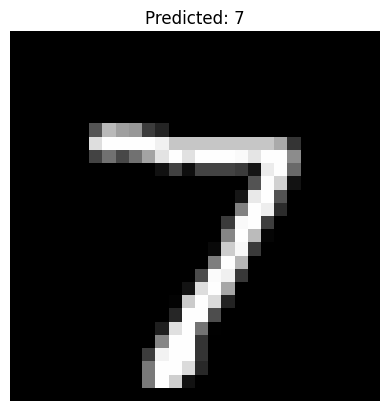

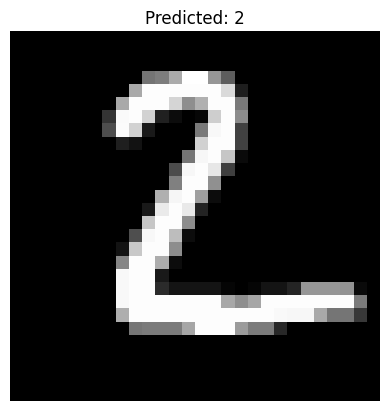

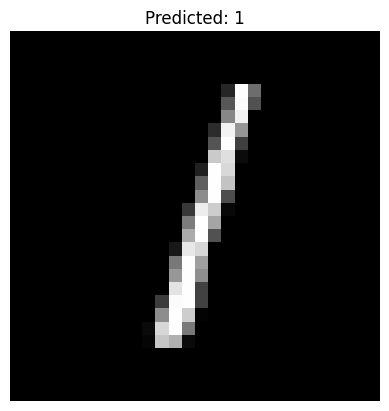

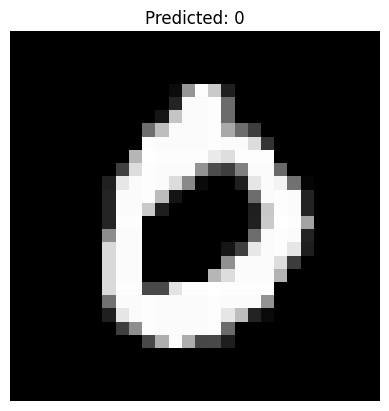

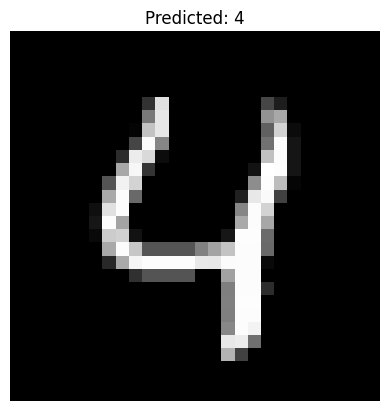

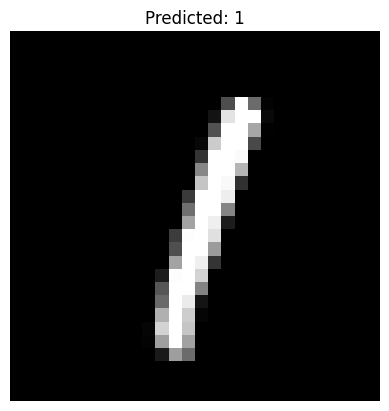

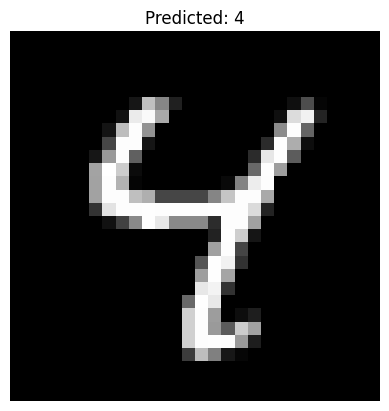

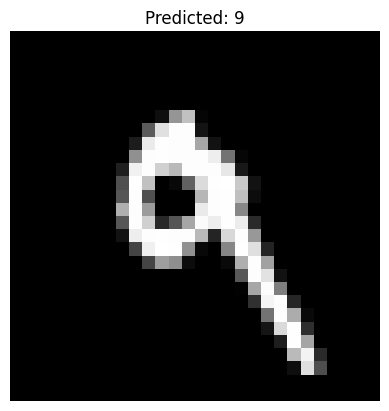

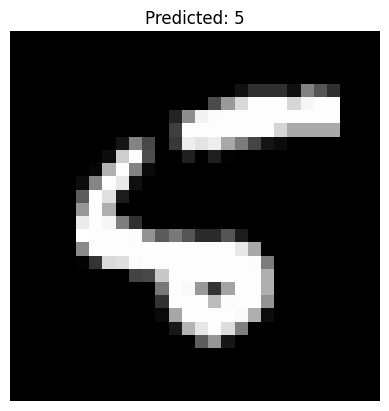

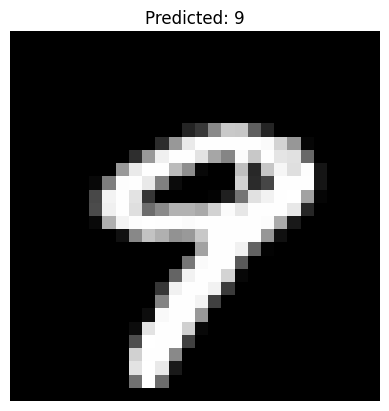

In [29]:
#----------
## Visualize predicted and image
#----------

import matplotlib.pyplot as plt

for i, image in enumerate(val_set['image'][:10]):
    print("="*50)
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {predicted[i].item()}")
    plt.axis('off')
    plt.show()